<a href="https://colab.research.google.com/github/guilhermecarva/guilhermecarva/blob/main/Sistemas_de_Recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados:

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5.
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados).

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Vamos utilizar uma função para criar nosso DataSet utilizando os dados de 2 arquivos csv´s

In [ ]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [ ]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Vamos preencher os dados faltantes com zeros

In [ ]:
ratings = R.fillna(0).values
ratings

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [ ]:
pd.DataFrame(ratings)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
1,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
2,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0
4,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
363,2.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,4.0,0.0,4.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Utilizaremos uma função para fazer a divisão dos dados em treino e teste. Nesta divisão serão retiradas n qtd de interações por usuários. Para este exercício iremos retirar 2 interações.

In [ ]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=qtd,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    return train, test

In [ ]:
train, test = train_test_split(ratings, qtd = 2)

In [ ]:
# Vamos dividir nosso DataSet de treino entre treino e validação
train, val = train_test_split(train, qtd = 2)

In [ ]:
#Podemos fazer um check para garantir que a soma/junção dos 3 datasets são iguais ao dataset original (ratings)
(train + val + test) == ratings

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
import time

class MatrixFactorization():

    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta

    def fit(self):
        t0 = time.time()

        R = self.df.values
        N, M = R.shape

        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)

        lista_erro_step = []

        #loop
        for step in range(self.steps):

            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])

            lista_erro_step.append(mse_total_step)

        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        #print("Fatoração concluída. Tempo aproximado:", round((t1-t0),2), 'segundos(s).')

    def predict(self):
        return self.P.dot(self.Q)

    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

    def printErro(self):
        return self.lista_erro_step[len(self.lista_erro_step) - 1]

#### Utilizando a classe de fatorização acima, vamos instanciar a função com parâmetros aleatórios para teste.

In [ ]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                          K = 3, steps = 200, alpha = 0.0001, beta = 0.2)

In [ ]:
#fitamos o modelo
fat.fit()

In [ ]:
#predição usando apenas os dados de treino
pd.DataFrame(fat.predict(), columns = R.columns, index = R.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,4.10,3.39,3.09,3.73,3.54,3.13,4.11,4.27,4.22,4.00,...,3.93,3.44,3.62,1.72,2.38,3.56,3.44,2.32,4.16,2.98
User_1,3.54,2.97,2.76,3.23,3.08,2.74,3.54,3.68,3.62,3.55,...,3.46,2.90,3.12,1.58,2.02,3.07,3.00,2.03,3.68,2.47
User_2,3.42,2.89,2.61,3.12,2.97,2.67,3.45,3.55,3.55,3.36,...,3.34,2.86,3.04,1.46,1.96,2.92,2.92,2.00,3.50,2.42
User_3,4.27,3.69,3.29,3.91,3.73,3.43,4.35,4.41,4.50,4.19,...,4.27,3.56,3.82,1.83,2.42,3.57,3.71,2.61,4.39,2.94
User_4,4.01,3.26,2.99,3.64,3.44,3.00,4.00,4.19,4.09,3.89,...,3.78,3.37,3.53,1.66,2.36,3.54,3.32,2.20,4.04,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.04,2.61,2.43,2.78,2.67,2.41,3.05,3.15,3.12,3.10,...,3.04,2.46,2.69,1.41,1.71,2.61,2.62,1.80,3.21,2.04
User_363,3.84,3.23,3.13,3.51,3.38,2.96,3.79,4.00,3.84,4.01,...,3.78,3.05,3.36,1.87,2.17,3.40,3.24,2.15,4.12,2.59
User_364,4.00,3.45,3.31,3.67,3.54,3.17,3.97,4.14,4.04,4.21,...,4.03,3.15,3.53,1.98,2.22,3.46,3.45,2.34,4.33,2.59
User_365,3.26,2.68,2.37,2.96,2.79,2.48,3.30,3.40,3.40,3.09,...,3.10,2.79,2.89,1.28,1.92,2.81,2.73,1.86,3.23,2.44


In [ ]:
#Vamos comparar nosso DataSet de validação com os dados preditos
pd.DataFrame(val, columns = R.columns, index = R.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
User_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
User_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
User_363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_364,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
User_365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Fazendo uma análise rápida apenas visualmente parece que nosso modelo esta predizendo bons resultados. <br> Vamos plotar a curva de erros / steps

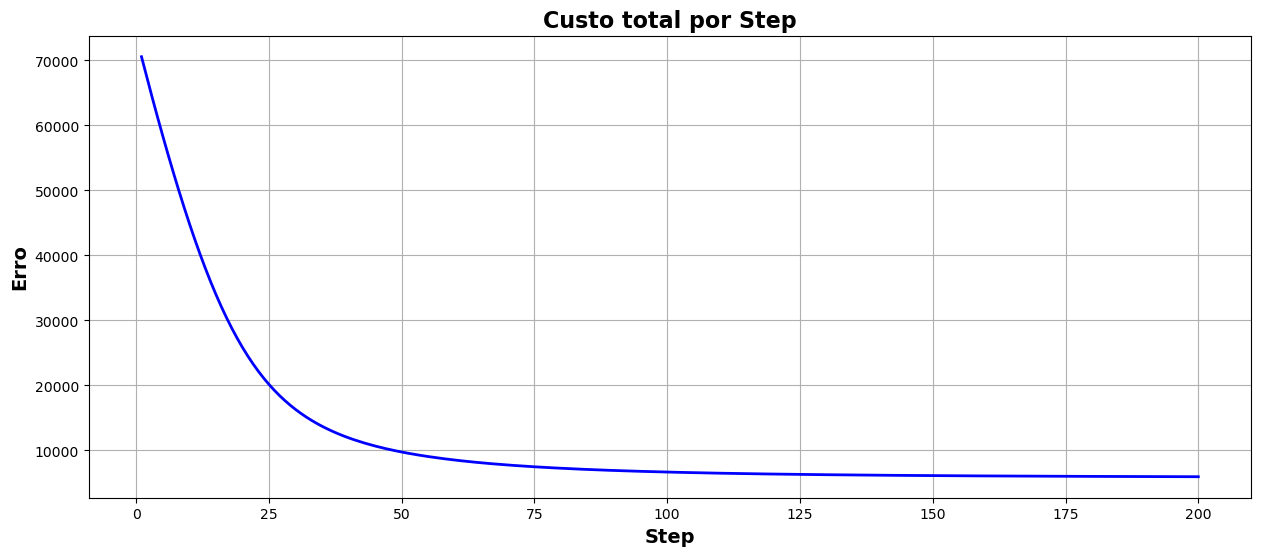

In [ ]:
fat.print_MSE_steps()

#### Podemos observar que o erro diminui drasticamente a apenas com 50 steps. Como testamos com parâmetros aleatórios, podemos tentar descobrir outros parâmetros que reduzam este erro ainda mais. <br> <br>Abaixo criaremos um looping utilizando diferentes parâmetros e utilizaremos os parâmetros que obtiverem menor erro para treinar nosso modelo e fazer uma nova comparação com os datasets de validação e teste.

In [ ]:
lista_erro = []
t0 = time.time()
for ks in [3, 5, 7, 9]:
    for step in [200, 400, 600]:
        for alphas in [0.01, 0.001, 0.0001, 0.0002]:
            for betas in [0.1, 0.2, 0.3]:
                fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                                K = ks, steps = step, alpha = alphas, beta = betas)
                fat.fit()
                erro = fat.printErro()
                #print(f'\n k = {ks}, steps = {step}, alpha = {alphas}, beta = {betas}, erro --> {round(erro,2)}\n')
                lista_erro.append(['k',ks, 'steps',step, 'alpha',alphas, 'beta',betas, 'erro',round(erro,2)])
t1 = time.time()
print("Looping concluído. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')

Looping concluído. Tempo aproximado: 122 minuto(s).


In [ ]:
pd.DataFrame(lista_erro).sort_values(9).style.hide()

0,1,2,3,4,5,6,7,8,9
k,9,steps,600,alpha,0.001000,beta,0.100000,erro,2409.280000
k,9,steps,600,alpha,0.010000,beta,0.100000,erro,2428.580000
k,9,steps,400,alpha,0.010000,beta,0.100000,erro,2439.130000
k,9,steps,200,alpha,0.010000,beta,0.100000,erro,2475.830000
k,9,steps,400,alpha,0.001000,beta,0.100000,erro,2506.430000
k,7,steps,600,alpha,0.001000,beta,0.100000,erro,2954.910000
k,9,steps,600,alpha,0.001000,beta,0.200000,erro,2984.740000
k,9,steps,400,alpha,0.010000,beta,0.200000,erro,3002.070000
k,9,steps,600,alpha,0.010000,beta,0.200000,erro,3012.620000
k,7,steps,600,alpha,0.010000,beta,0.100000,erro,3037.270000


#### Dos testes acima, temos que os parâmetros que obtiveram o menor erro foram : <br>k =  9 <br>steps =  600<br>alpha = 0.001<br>beta = 0.1

In [ ]:
fat_ = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                          K = 9, steps = 600, alpha = 0.001, beta = 0.1)

In [ ]:
fat_.fit()

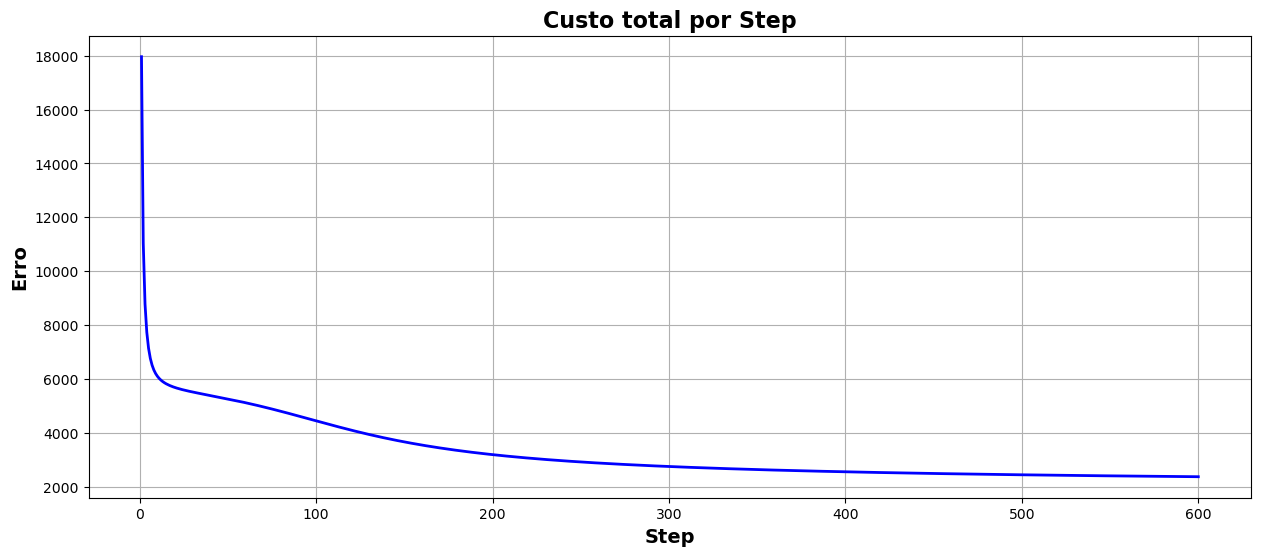

In [ ]:
fat_.print_MSE_steps()

#### Fitamos o modelo com os parâmetros escolhidos e vamos agora comparar suas predições com o DataSet de validação

In [ ]:
#predição usando apenas os dados de treino
p = pd.DataFrame(fat_.predict(), columns = R.columns, index = R.index).round(2).values

In [ ]:
p.shape

(367, 80)

In [ ]:
#Vamos comparar nosso DataSet de validação com os dados preditos
v = pd.DataFrame(val, columns = R.columns, index = R.index).round(2).values

In [ ]:
v.shape

(367, 80)

In [ ]:
R.shape

(367, 80)

#### Vamos fazer um looping para comparar cada nota do DataSet de validação não nulo com o Dataset predito

In [ ]:
lista_var = []
lista_mse = []
mse_total = 0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] > 0:
            eij = v[i][j] - p[i][j]
            mse_total += (eij)**2
            lista_var.append(eij)
lista_mse.append(mse_total)


In [ ]:
lista_mse

[796.6768999999999]

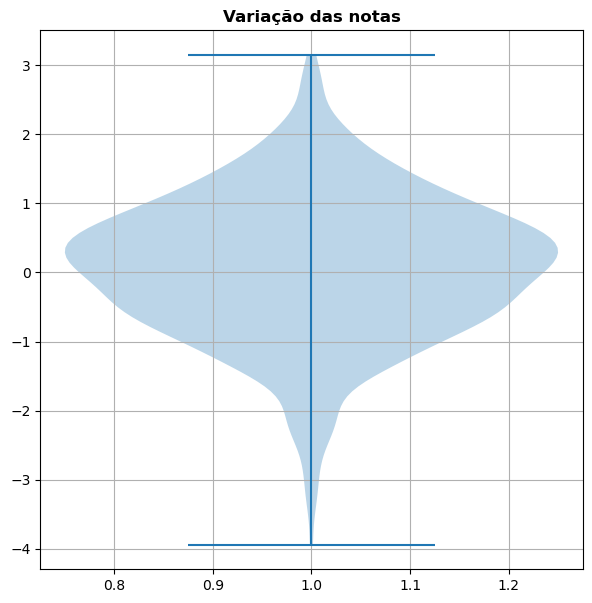

In [ ]:
plt.figure(figsize=[7,7])
plt.title("Variação das notas", fontsize = 12, fontweight = 'bold')
plt.violinplot(lista_var)
plt.grid()
plt.show()

#### Fazendo a subtração dos dados de validação com o predito, observamos uma grande concentração de variações do tamanho -1,8 e +2. O que me parece uma variação alta dentro de uma nota de 0 a 5. <br> Vamos tentar aumentar o parâmetro k para 15 e ver o resultado.

In [ ]:
fat_1 = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                          K = 15, steps = 600, alpha = 0.001, beta = 0.1)

In [ ]:
fat_1.fit()

In [ ]:
fat_1.printErro()

1456.0549018505392

In [ ]:
p = pd.DataFrame(fat_1.predict(), columns = R.columns, index = R.index).round(2).values

In [ ]:
lista_var = []
lista_mse = []
mse_total = 0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] > 0:
            eij = v[i][j] - p[i][j]
            mse_total += (eij)**2
            lista_var.append(eij)
lista_mse.append(mse_total)

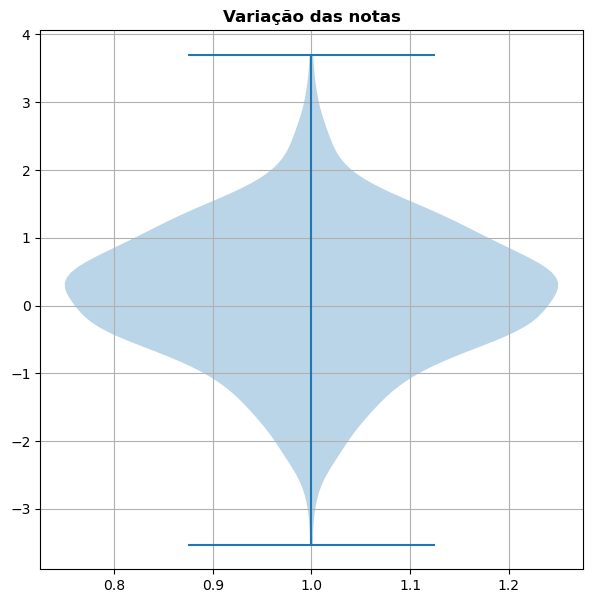

In [ ]:
plt.figure(figsize=[7,7])
plt.title("Variação das notas", fontsize = 12, fontweight = 'bold')
plt.violinplot(lista_var)
plt.grid()
plt.show()

In [ ]:
lista_mse

[803.0128999999998]

In [ ]:
pd.DataFrame(lista_var).mean()

0    0.151185
dtype: float64

In [ ]:
pd.DataFrame(lista_var).std()

0    1.035677
dtype: float64

#### A variação não parece ter alterado muito, apenas está com uma distribuição mais homogênea. A média das variações entre os datasets de validção e predito está em 0.15 com um desvio padrão de 1.04. <br> Ou seja, não parecem estar divergindo muito, no entanto, acredito que possamos encontrar melhores parâmetros para reduzir ainda mais o erro. <br> Vamos tentar outros parâmetros.

In [ ]:
lista_erro = []
t0 = time.time()
for ks in [9,13,15,17,19]:
    for step in [600]:
        for alphas in [0.001, 0.002]:
            for betas in [0.1, 0.2]:
                fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                                K = ks, steps = step, alpha = alphas, beta = betas)
                fat.fit()
                erro = fat.printErro()
                #print(f'\n k = {ks}, steps = {step}, alpha = {alphas}, beta = {betas}, erro --> {round(erro,2)}\n')
                lista_erro.append(['k',ks, 'steps',step, 'alpha',alphas, 'beta',betas, 'erro',round(erro,2)])
t1 = time.time()
print("Looping concluído. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')

Looping concluído. Tempo aproximado: 55 minuto(s).


In [ ]:
pd.DataFrame(lista_erro).sort_values(9).style.hide()

0,1,2,3,4,5,6,7,8,9
k,19,steps,600,alpha,0.002000,beta,0.100000,erro,931.640000
k,17,steps,600,alpha,0.002000,beta,0.100000,erro,1062.760000
k,19,steps,600,alpha,0.001000,beta,0.100000,erro,1079.840000
k,17,steps,600,alpha,0.001000,beta,0.100000,erro,1245.510000
k,15,steps,600,alpha,0.002000,beta,0.100000,erro,1266.400000
k,15,steps,600,alpha,0.001000,beta,0.100000,erro,1421.380000
k,13,steps,600,alpha,0.002000,beta,0.100000,erro,1514.060000
k,13,steps,600,alpha,0.001000,beta,0.100000,erro,1723.580000
k,19,steps,600,alpha,0.002000,beta,0.200000,erro,1840.260000
k,17,steps,600,alpha,0.002000,beta,0.200000,erro,1958.430000


#### Conseguimos reduzir o erro para 932. Aumentando o parâmetro k. Agora, iremos tentar aumentar ainda mais o k e manter os demais parâmetros.

In [ ]:
lista_erro = []
t0 = time.time()
for ks in [19, 21, 23]:
    for step in [600]:
        for alphas in [0.002]:
            for betas in [0.1, 0.2]:
                fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                                K = ks, steps = step, alpha = alphas, beta = betas)
                fat.fit()
                erro = fat.printErro()
                #print(f'\n k = {ks}, steps = {step}, alpha = {alphas}, beta = {betas}, erro --> {round(erro,2)}\n')
                lista_erro.append(['k',ks, 'steps',step, 'alpha',alphas, 'beta',betas, 'erro',round(erro,2)])
t1 = time.time()
print("Looping concluído. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')

Looping concluído. Tempo aproximado: 24 minuto(s).


In [ ]:
pd.DataFrame(lista_erro).sort_values(9).style.hide()

0,1,2,3,4,5,6,7,8,9
k,23,steps,600,alpha,0.002000,beta,0.100000,erro,705.310000
k,21,steps,600,alpha,0.002000,beta,0.100000,erro,790.200000
k,19,steps,600,alpha,0.002000,beta,0.100000,erro,923.880000
k,23,steps,600,alpha,0.002000,beta,0.200000,erro,1699.190000
k,21,steps,600,alpha,0.002000,beta,0.200000,erro,1762.580000
k,19,steps,600,alpha,0.002000,beta,0.200000,erro,1830.270000


#### Aumentando o k de 19 para 23 conseguimos reduzir o erro para 705. Me parece um valor razoável. Vamos fazer as comparações para ver o que encontramos.

In [ ]:
fat_2 = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index),
                          K = 23, steps = 600, alpha = 0.002, beta = 0.1)

In [ ]:
fat_2.fit()

In [ ]:
fat_2.printErro()

711.071712839631

In [ ]:
p = pd.DataFrame(fat_2.predict(), columns = R.columns, index = R.index).round(2).values

In [ ]:
lista_var = []
lista_mse = []
mse_total = 0
for i in range(len(v)):
    for j in range(len(v[i])):
        if v[i][j] > 0:
            eij = v[i][j] - p[i][j]
            mse_total += (eij)**2
            lista_var.append(eij)
lista_mse.append(mse_total)

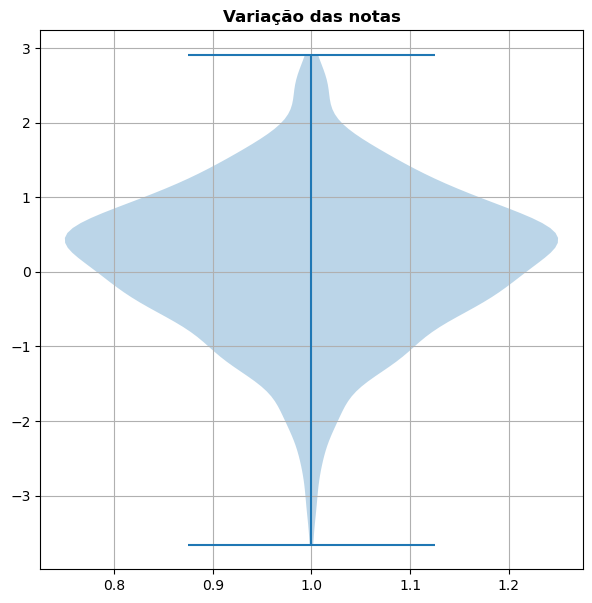

média da variação  0    0.141199
dtype: float64
desvio padrão das variações  0    0.999295
dtype: float64


In [ ]:
plt.figure(figsize=[7,7])
plt.title("Variação das notas", fontsize = 12, fontweight = 'bold')
plt.violinplot(lista_var)
plt.grid()
plt.show()
print('média da variação ',pd.DataFrame(lista_var).mean())
print('desvio padrão das variações ',pd.DataFrame(lista_var).std())

#### Obtivemos uma pequena redução no desvio padrão, o que já era esperado devido ao menor erro. Podemos agora fazer uma comparação com o DataSet de teste.

In [ ]:
t = pd.DataFrame(test, columns = R.columns, index = R.index).round(2).values

In [ ]:
lista_var = []
lista_mse = []
mse_total = 0
for i in range(len(t)):
    for j in range(len(t[i])):
        if t[i][j] > 0:
            eij = t[i][j] - p[i][j]
            mse_total += (eij)**2
            lista_var.append(eij)
lista_mse.append(mse_total)

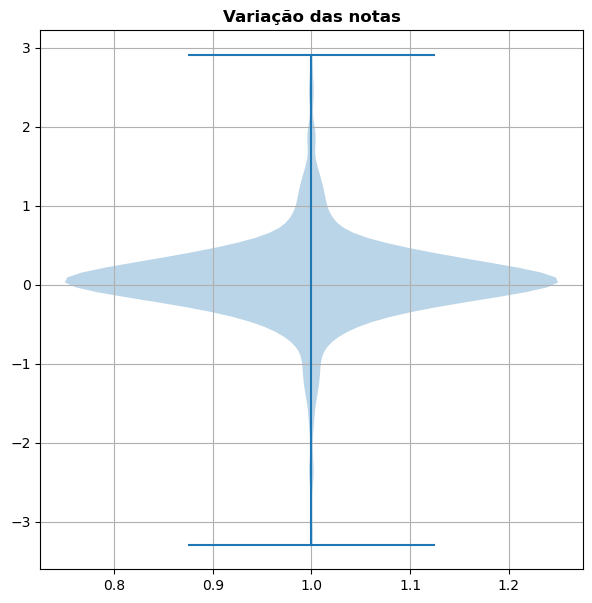

média da variação  0    0.061553
dtype: float64
desvio padrão das variações  0    0.565984
dtype: float64


In [ ]:
plt.figure(figsize=[7,7])
plt.title("Variação das notas", fontsize = 12, fontweight = 'bold')
plt.violinplot(lista_var)
plt.grid()
plt.show()
print('média da variação ',pd.DataFrame(lista_var).mean())
print('desvio padrão das variações ',pd.DataFrame(lista_var).std())

### Obtivemos um resultado excelente no Dataset de teste, com uma média de variação quase zero e um desvio padrão de apenas 0.6